Esta línea instala la biblioteca `yfinance` si aún no está instalada en tu entorno de Google Colab. yfinance es una biblioteca de Python que se utiliza para acceder a datos financieros de Yahoo Finance.

In [ ]:
pip install pandas yfinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import warnings

In [ ]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

Importamos la basa de datos

In [ ]:
import gdown
import pandas as pd

import shutil

# Ruta del archivo en Google Drive
ruta_drive = "/content/drive/My Drive/GOOG-year.csv"

# Ruta de destino en Google Colab
ruta_colab = "/content/GOOG-year.csv"

# Copia el archivo desde Google Drive a Google Colab
shutil.copy(ruta_drive, ruta_colab)





'/content/GOOG-year.csv'

In [ ]:
import pandas as pd

# Ruta del archivo copiado en Google Colab
ruta_colab = "/content/GOOG-year.csv"

# Carga el archivo en un DataFrame de pandas
df = pd.read_csv(ruta_colab)

# Muestra las primeras filas del DataFrame
print(df.head())


         Date        Open        High        Low       Close   Adj Close  \
0  2022-10-11   98.250000  100.120003  97.250000   98.050003   98.050003   
1  2022-10-12   98.269997   99.648003  97.669998   98.300003   98.300003   
2  2022-10-13   95.930000  100.529999  95.269997   99.709999   99.709999   
3  2022-10-14  100.625000  101.290001  97.029999   97.180000   97.180000   
4  2022-10-17   99.519997  101.769997  99.510002  100.779999  100.779999   

     Volume  
0  21617700  
1  17343400  
2  32812200  
3  22624800  
4  23311600  


1) **`minmax`** = `MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))`: Aquí se crea un objeto MinMaxScaler llamado minmax y se ajusta a un subconjunto de los datos del DataFrame df. El subconjunto se selecciona utilizando `df.iloc[:, 4:5]`, lo que significa que se están utilizando solo las columnas 4 hasta 5 (columna 4). Luego, `astype('float32')` se utiliza para asegurarse de que los datos se representen como números de punto flotante de 32 bits.

2) **`df_log`** = `minmax.transform(df.iloc[:, 4:5].astype('float32'))`: En esta línea, se aplica la transformación de escala a los datos seleccionados usando el objeto minmax que se creó anteriormente. Los datos escalados se almacenan en la variable `df_log`.

3) **`df_log`** = `pd.DataFrame(df_log)`: Luego, los datos escalados se convierten nuevamente en un DataFrame de pandas y se almacenan en la variable `df_log`.

4) **`df_log.head`**(): Finalmente, se muestra una vista previa de los primeros registros de `df_log` utilizando el método `.head()`. Esto te permite ver cómo se ven los datos después de aplicar la transformación de escala.

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.250129
1,0.254424
2,0.278646
3,0.235183
4,0.297028


Este fragmento de código se encarga de dividir un DataFrame de datos en conjuntos de entrenamiento y prueba.

**`test_size`** = 30 y **`simulation_size`** = 10: Aquí se definen dos variables, `test_size` que indica el tamaño del conjunto de prueba (en este caso, 30) y `simulation_size` (en este caso, 10)

**`df_train`** = `df_log.iloc[:-test_size]`: Esto crea un nuevo DataFrame llamado` df_train` que contiene los datos de entrenamiento. Toma las filas de `df_log` desde el principio hasta el índice `-test_size`. En otras palabras, se excluyen las últimas 30 filas del DataFrame original.

**`df_test`** = `df_log.iloc[-test_size:]`: Aquí se crea otro DataFrame llamado `df_test` que contiene los datos de prueba. Toma las últimas 30 filas del DataFrame original, que corresponden al tamaño de prueba definido en `test_size`.

**`df.shape`**, **`df_train.shape`**, **`df_test.shape`**: Finalmente, estas líneas muestran las dimensiones (número de filas y columnas) de los DataFrames `df`, `df_train`, y `df_test`. Esto proporciona información sobre la cantidad de datos en cada conjunto.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

Clase del Modelo **`(Model)`**:
Esta clase define la arquitectura del modelo de la red neuronal.

**`__init__`**: El constructor de la clase acepta varios parámetros, incluyendo la tasa de aprendizaje `(learning_rate)`, el número de capas de la red `(num_layers)`, el tamaño de la capa `(size_layer)`, el tamaño de entrada `(size)`, el tamaño de salida `(output_size)` y un hiperparámetro opcional llamado `forget_bias`. Dentro del constructor, se construye la arquitectura de la red.

**`lstm_cell`**: Esta función interna se utiliza para crear celdas GRU (Gated Recurrent Unit) con el tamaño especificado.

**`rnn_cells`**: Se crea una pila de capas de celdas GRU `(una MultiRNNCell) `utilizando la función lstm_cell. El número de capas y el tamaño de las capas se definen por los parámetros `num_layers` y `size_layer`.

**`self.X y self.Y`**: Estos son marcadores de posición de TensorFlow que se utilizan para alimentar datos de entrada (X) y etiquetas de salida (Y) al modelo.

**`drop`**: Se aplica un mecanismo de abandono (dropout) a las celdas GRU utilizando tf.contrib.rnn.DropoutWrapper.

**`self.hidden_layer`**: Otro marcador de posición que se utiliza para proporcionar el estado oculto inicial a la red.

**`self.outputs`** y **`self.last_state`**: Se realiza la operación de propagación hacia adelante utilizando tf.nn.dynamic_rnn. Los resultados intermedios y el último estado se almacenan en `self.outputs` y `self.last_state`, respectivamente.

**`self.logits`**: Se conecta una capa densa a la salida de la red para generar las predicciones.

**`self.cost`**: Se define la función de costo, que es el error cuadrático medio (MSE) entre las predicciones (self.logits) y las etiquetas reales (self.Y).

**`self.optimizer`**: Se utiliza el optimizador Adam para minimizar la función de costo durante el entrenamiento.

Funciones **`calculate_accuracy`** y **`anchor`**:
Estas son funciones de utilidad adicionales

`calculate_accuracy`: Calcula la precisión de las predicciones comparando los valores reales con las predicciones. Los valores se transforman para evitar divisiones por cero, y la precisión se calcula como un porcentaje basado en la diferencia entre los valores reales y las predicciones.

`anchor`: Esta función suaviza una señal de datos utilizando un filtro exponencial ponderado. El valor de suavizado se controla mediante el parámetro weight. La función devuelve una señal suavizada.

In [ ]:
import tensorflow as tf
import numpy as np

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias=0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple=False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob=forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state=self.hidden_layer, dtype=tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer


**`num_layers`** = 1: Este hiperparámetro define el número de capas en el modelo RNN. En este caso, se ha configurado para tener una sola capa.

**`size_layer`** = 128: Este hiperparámetro establece el tamaño de las capas ocultas en el modelo RNN. Cada capa oculta contiene 128 unidades neuronales.

**`timestamp`** = 5: Indica el número de pasos de tiempo o "ventanas" que se utilizan como entrada para el modelo. En este caso, el modelo considera los últimos 5 pasos de tiempo para hacer predicciones.

**`epoch`** = 300: Este hiperparámetro determina la cantidad de épocas de entrenamiento que se llevarán a cabo. Una época completa significa que el modelo ha visto y ajustado a todos los datos de entrenamiento una vez. En este caso, el entrenamiento se llevará a cabo durante 300 épocas.

**`dropout_rate`** = 0.8: El hiperparámetro de tasa de abandono controla la probabilidad de que se aplique el abandono a las unidades de la red durante el entrenamiento. En este caso, se ha configurado en 0.8, lo que significa que se aplica el 80% de abandono.

**`future_day`** = test_size: Esta variable representa el número de días futuros para los que se desea hacer predicciones. Está configurada para ser igual al tamaño del conjunto de prueba (test_size), lo que implica que se desean realizar predicciones para la misma cantidad de días que se utilizan para evaluar el modelo.

**`learning_rate`** = 0.01: La tasa de aprendizaje controla la velocidad con la que el modelo se ajusta a los datos durante el entrenamiento. Un valor más alto significa un ajuste más rápido, pero puede ser inestable, mientras que un valor más bajo implica un ajuste más lento pero más estable. En este caso, se ha configurado en 0.01.

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01


Este fragmento de código es una función llamada `forecast` que se utiliza para realizar predicciones utilizando un modelo de red neuronal LSTM (Long Short-Term Memory) en series temporales.

1) Configuración del modelo LSTM: En primer lugar, la función configura un modelo de red neuronal secuencial utilizando la biblioteca Keras. El modelo consta de dos capas LSTM, seguidas de una capa densa. Se utiliza la función de pérdida `mean_squared_error` y el optimizador `adam` para compilar el modelo.

2) Preparación de datos de entrada: La función prepara los datos de entrada para el entrenamiento del modelo. Divide el conjunto de entrenamiento en lotes de datos con un tamaño de ventana especificado por `timestamp`. Luego, itera a través de los lotes y ajusta el modelo utilizando model.`train_on_batch`.

3) Predicciones de datos de entrenamiento: La función realiza predicciones en el conjunto de entrenamiento utilizando el modelo entrenado. Almacena las predicciones en `output_predict`.

4) Generación de predicciones futuras: Después de entrenar el modelo, la función genera predicciones futuras durante `future_day` días. Utiliza las predicciones anteriores como entrada para predecir el siguiente valor en la serie temporal. Las predicciones se almacenan en `output_predict`.

5) Inversión de la escala de los datos: Las predicciones se escalan nuevamente al rango original utilizando `minmax.inverse_transform`. También se aplica la función anchor para suavizar las predicciones.

6) Resultado final: La función devuelve las predicciones para los días de prueba, que se almacenan en `deep_future`.

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tqdm import tqdm

def forecast():
    model = Sequential()
    model.add(LSTM(size_layer, input_shape=(timestamp, df_log.shape[1]), return_sequences=True))
    model.add(LSTM(size_layer, return_sequences=True))
    model.add(Dense(df_log.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')

    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
          index = min(k + timestamp, df_train.shape[0] - 1)
          batch_x = np.zeros((1, 5, 1))
          batch_x[0, :index - k, 0] = df_train.iloc[k : index, :].values.reshape(-1)
          batch_y = np.zeros((1, 5, 1))
          batch_y[0, :index - k, 0] = df_train.iloc[k + 1 : index + 1, :].values.reshape(-1)
          loss = model.train_on_batch(batch_x, batch_y)
          total_loss.append(loss)
          pbar.set_postfix(cost=np.mean(total_loss))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0].values
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = model.predict(df_train.iloc[k : k + timestamp, :].values.reshape(1, timestamp, -1))
        output_predict[k + 1 : k + timestamp + 1] = out_logits[0]

    if upper_b != df_train.shape[0]:
        out_logits = model.predict(df_train.iloc[upper_b:, :].values.reshape(1, df_train.shape[0] - upper_b, -1))
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits[0]
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value = out_logits[0]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = model.predict(o.reshape(1, timestamp, -1))
        # Almacena solo la última predicción en la posición adecuada
        output_predict[-future_day + i, 0] = out_logits[0, -1, 0]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

Este fragmento de código realizará múltiples simulaciones de predicciones utilizando la función `forecast`

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 300/300 [05:01<00:00,  1.00s/it, cost=0.00187]


1/1 [==============================] - 0s 23ms/step
simulation 2


train loop: 100%|██████████| 300/300 [05:02<00:00,  1.01s/it, cost=0.00174]


1/1 [==============================] - 0s 33ms/step
simulation 3


train loop: 100%|██████████| 300/300 [05:03<00:00,  1.01s/it, cost=0.00179]


1/1 [==============================] - 0s 22ms/step
simulation 4


train loop: 100%|██████████| 300/300 [05:00<00:00,  1.00s/it, cost=0.00165]


1/1 [==============================] - 0s 36ms/step
simulation 5


train loop: 100%|██████████| 300/300 [05:12<00:00,  1.04s/it, cost=0.00172]


1/1 [==============================] - 0s 28ms/step
simulation 6


train loop: 100%|██████████| 300/300 [05:07<00:00,  1.03s/it, cost=0.0018]


1/1 [==============================] - 0s 24ms/step
simulation 7


train loop: 100%|██████████| 300/300 [05:01<00:00,  1.01s/it, cost=0.00183]


1/1 [==============================] - 0s 24ms/step
simulation 8


train loop: 100%|██████████| 300/300 [05:08<00:00,  1.03s/it, cost=0.00164]


1/1 [==============================] - 0s 22ms/step
simulation 9


train loop: 100%|██████████| 300/300 [05:10<00:00,  1.03s/it, cost=0.00184]


1/1 [==============================] - 0s 24ms/step
simulation 10


train loop: 100%|██████████| 300/300 [05:22<00:00,  1.07s/it, cost=0.00166]


1/1 [==============================] - 0s 22ms/step


Este fragmento de código se utiliza para calcular la precisión de las predicciones realizadas en las simulaciones y para visualizar las predicciones junto con la tendencia real en un gráfico.

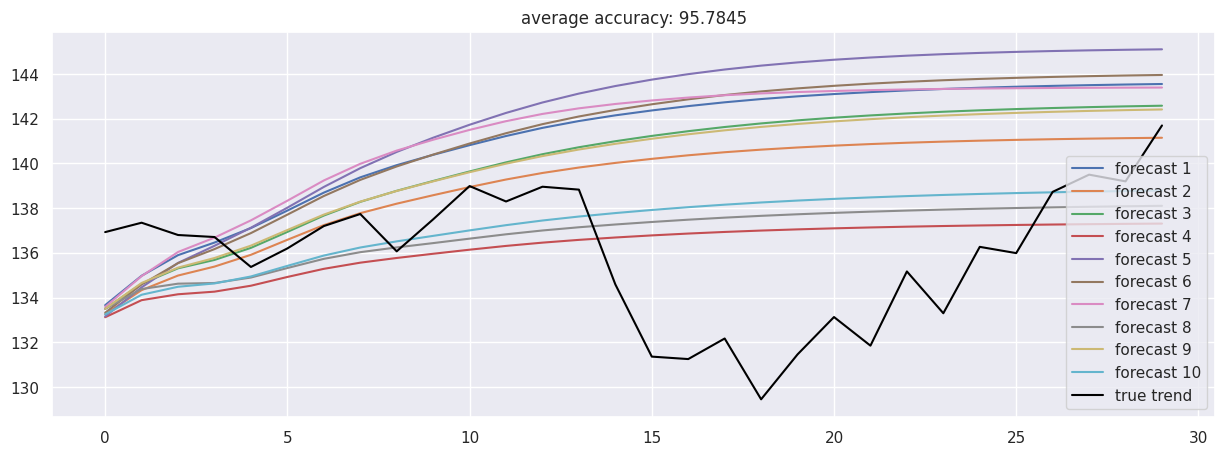

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()